In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
import time
import struct
import tensorflow as tf
import random as rd

from math import *
from array import array

from keras.src.ops import shape
# import keras._tf_keras.keras as keras 
# from keras._tf_keras.keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

# my project
from module.conf import PROJECT_DIR

# matplotlib.use("QTAgg")
%matplotlib inline

Load data:
- Train data: 60k 28x28 images
- Test data: 

In [4]:
mnist_path = "/data/sample/mnist"
training_images_filepath = "".join([PROJECT_DIR, mnist_path, "/train-images.idx3-ubyte"])
training_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/train-labels.idx1-ubyte"])
test_images_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-images.idx3-ubyte"])
test_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-labels.idx1-ubyte"])

def read_images_labels(images_filepath, labels_filepath) -> tuple:
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        # labels = array("B", file.read())
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())       
     
    images = []
    # for i in range(size):
    #     images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        # images[i][:] = img
        images.append(img)
    
    return images, labels

def load_data() -> tuple:
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (x_train, y_train),(x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

In [5]:
# print(f"{type(X_train[0])}")
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()


In [5]:
X_train = np.asarray(X_train)/255
y_train = np.asarray(y_train)
X_test  = np.asarray(X_test)/255
y_test  = np.asarray(y_test)

## 1. Activation functions:

### 1.1. Linear:
$ \begin{align}
f(\mathbf z) &= \mathbf z \\
\rightarrow \frac{\partial f(\mathbf z)}{\partial \mathbf z} &=\mathbf 1 \\ 
\end{align} $

In [6]:
def linear(z): return z
def grad_linear(z): return 1

### 1.2. ReLU:
$\begin{align}
ReLU(\mathbf z) &= \max(\mathbf z, \mathbf 0) \\
\rightarrow \frac{\partial ReLU(\mathbf z)}{\partial \mathbf z} &= \begin{cases}
z_i = 1 \text{ if } z_i > 0 \\
z_i = 0 \text{ if } z_i \leqslant 0 \\
\end{cases} \\
\end{align}$

In [7]:
def relu(z): return np.maximum(0, z)
def grad_relu(z): return np.array([1 if z_i > 0 else 0 for z_i in z])

In [8]:
z = np.array([1,-6, 3, 4, 0])
relu_z = relu(z)
relu_z
grad_relu_z = grad_relu(relu_z)
grad_relu_z

array([1, 0, 1, 1, 0])

### 1.2. Sigmoid:
$\begin{align}
\sigma(\mathbf z) &= \frac{1}{1 + e^{-z}} \\
\rightarrow \frac{\partial\sigma(\mathbf z)}{\partial \mathbf z} &= \sigma(\mathbf z)\cdot\left(1 - \sigma(\mathbf z)\right) \\ 
\end{align} $

In [9]:
def sigmoid(z): return 1/(1 + np.exp(-z))
def grad_sigmoid(z): return sigmoid(z) * (1 - sigmoid(z))    

In [10]:
z = np.array([1,-6, 3, 4, 0])
sigmoid(z)
grad_sigmoid(z)

array([0.19661193, 0.00246651, 0.04517666, 0.01766271, 0.25      ])

### 1.3. Softmax:
$\begin{align}
\sigma(\mathbf z) &= \frac{e^{\mathbf z}}{\sum_{i=1}^{C}e^{z_i}} \\
\rightarrow \frac{\partial \sigma(\mathbf z)}{\partial \mathbf z} &= \sigma(z_i) \cdot (\delta_{ij} - \sigma(z_j)) 
\rightarrow \delta_{ij} = \begin{cases} 
1 \text{ if } i = j \\
0 \text{ if } i \neq j  
\end{cases} \\
&= diag(\mathbf z) - \mathbf z * \mathbf z^T \\
C &\text{ is number of class} \\
diag &\text{ is diagonal matrix }
\end{align}$

In [11]:
# def softmax(z): return np.exp(z)/np.sum(np.exp(z))
# def grad_softmax(z): return np.diag(z) - np.outer(z,z)
def softmax(Z):
    Z_max = np.max(Z, axis=Z.ndim-1, keepdims=True)
    Z_exp = np.exp(Z - Z_max)
    Z_sum = np.sum(Z_exp, axis=Z.ndim-1, keepdims=True)
    return Z_exp / Z_sum

def grad_softmax(Z):
    S = softmax(Z)  # Tính softmax cho Z
    batch_size, num_classes = S.shape
    # Init Jacobian matrix: gradient foreach row
    dSoftmax = np.zeros((batch_size, num_classes, num_classes))
    for i in range(batch_size):
        # S_i is softmax for i-row
        s_i = S[i].reshape(-1, 1)  # Transpose
        # Jacobian matrix for i-row
        dSoftmax[i] = np.diagflat(s_i) - np.dot(s_i, s_i.T)
    return dSoftmax

In [12]:
z = np.array([[1,-6, 3, 4, 0],
              [1,-6, 3, 4, 0]])
softmax(z)
grad_softmax(z)

array([[[ 3.34679867e-02, -1.09608994e-06, -8.88170879e-03,
         -2.41429876e-02, -4.42194243e-04],
        [-1.09608994e-06,  3.16139440e-05, -8.09907007e-06,
         -2.20155550e-05, -4.03228955e-07],
        [-8.88170879e-03, -8.09907007e-06,  1.90551096e-01,
         -1.78393890e-01, -3.26739807e-03],
        [-2.41429876e-02, -2.20155550e-05, -1.78393890e-01,
          2.11440602e-01, -8.88170879e-03],
        [-4.42194243e-04, -4.03228955e-07, -3.26739807e-03,
         -8.88170879e-03,  1.25917043e-02]],

       [[ 3.34679867e-02, -1.09608994e-06, -8.88170879e-03,
         -2.41429876e-02, -4.42194243e-04],
        [-1.09608994e-06,  3.16139440e-05, -8.09907007e-06,
         -2.20155550e-05, -4.03228955e-07],
        [-8.88170879e-03, -8.09907007e-06,  1.90551096e-01,
         -1.78393890e-01, -3.26739807e-03],
        [-2.41429876e-02, -2.20155550e-05, -1.78393890e-01,
          2.11440602e-01, -8.88170879e-03],
        [-4.42194243e-04, -4.03228955e-07, -3.26739807e-03,
  

## 2. Loss function:

### 2.1. Cross Entropy:
$\begin{align}
CrossEntropy = - \log(\hat{y}_{true})\\
\end{align}$

### 2.2. Categorical Crossentropy:
$\begin{align}
Y &\text{ is label in one-hot matrix } N \times C  \\
\hat{Y} &\text{ is predicted matrix } N \times C \\
C &\text{ is number of classes}\\
L &= -\sum_{i=1}^{C} Y_i \log(\hat{Y}_{i}) \\
\hat{Y}_{i,j} &= \frac{exp(Z_{i,j})}{\sum_{k=1}^{C} exp(Z_{i,k})} \\
\rightarrow \mathcal L &= -\frac{1}{N} \sum_{i=1}^{N}\sum_{j=1}^{C} Y_{i,j} \log(\hat{Y}_{i,j}) \\
&= -\frac{1}{N} \sum_{i=1}^{N} \log(\hat{Y}_{i,true}) \\
\hat{Y}_{i,true} &\text{ is predicted result corresponding to one-hot is 1}
\end{align}$

Gradient:
$\begin{align}
\frac{\partial L}{\partial Z} &= \hat{Y}_{i,j} - Y_{i,j} \\
\end{align}$

### 2.3. Sparse Categorical Crossentropy:
$ \begin{align}
\hat{Y} &= A_n = softmax(Z) \\
Z &\text{ is } n \times C \text{ matrix. n is number of samples, C is number of classes} \\
CrossEntropy_i &= -\log(\hat{y}_{i, y_{sparse}}) \\
CrossEntropy &\text{ is a vector size n} \\
\rightarrow \frac{\partial L}{\partial Z_{i,j}} &= \hat{Y}_{i,j} - \delta(j, y_{sparse,i}) 
\rightarrow \delta(j, y_{sparse,i}) = \begin{cases}
1 \text{ if } j = y_{sparse,i} \\
0 \text{ if } j \neq y_{sparse,i}\\
\end{cases} \\
\rightarrow \frac{\partial L}{\partial Z_n} &= \hat{Y} - Y = \hat{Y} - SparseLabels \\
SparseLabels &\text{ can be considered as one-hot matrix}
\end{align} $

In [13]:
# should apply the Vectorization
def delta_kronecker_matrix(y_train, mY_pred):
    """
    Transform to one-hot encoding
    y_train: a vector size n
    mY_pred: a matrix (C, n)
    """
    mY_train = np.zeros(shape=mY_pred.shape)
    for i in range(len(y_train)): mY_train[i][y_train[i]] = 1
    return mY_train

def sparse_categorical_crossentropy_Z(y_train, mY_pred):
    y_pred = np.array([mY_pred[i][y_train[i]] for i in range(len(y_train))])
    return -np.sum(np.log(y_pred))

def grad_sparse_categorical_crossentropy_Z(y_train, mY_pred):
    return mY_pred - delta_kronecker_matrix(y_train=y_train, mY_pred=mY_pred)

def sparse_categorical_crossentropy(y_true, y_pred):
    # Loss func
    loss = -np.log(y_pred[range(len(y_pred)), y_true])
    return loss

def grad_sparse_categorical_crossentropy(y_true, y_pred):
    # Grad
    grad = np.zeros_like(y_pred)
    grad[range(len(y_pred)), y_true] = -1 / y_pred[range(len(y_pred)), y_true]  # Grad for true-class
    return grad

In [14]:
# test detal_kronecker_matrix
y_train_validate = np.array([0, 2, 2, 1, 0])
mY_pred = np.array([[0.2, 0.1 , 0.3],
                    [0.3, 0.2, 0.7],
                    [0.3, 0.2, 0.7],
                    [0.3, 0.2, 0.2],
                    [0.3, 0.2, 0.4]])
delta = delta_kronecker_matrix(y_train_validate, mY_pred)
delta

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [15]:
cross_entropy = sparse_categorical_crossentropy(y_train_validate, mY_pred)
print("%.15f" % cross_entropy)

TypeError: only length-1 arrays can be converted to Python scalars

In [16]:
import numpy as np
from scipy.sparse import csr_matrix
# ex
# [[0, 0, 0, 0],
#  [5, 8, 0, 0],
#  [0, 0, 3, 0],
#  [0, 6, 0, 0]]
#

data = np.array([5, 8, 3, 6, 7])        # values
indices = np.array([0, 1, 2, 1, 0])     # col index for each value
indptr = np.array([0, 2, 3, 4, 5])      # start - end in data values
csr_m = csr_matrix((data, indices, indptr), shape=(4, 4))
csr_m.toarray()


array([[5, 8, 0, 0],
       [0, 0, 3, 0],
       [0, 6, 0, 0],
       [7, 0, 0, 0]])

## 3. Optimizers: 

### 3.1. SGD
$\begin{align}
\theta &= \theta - \eta \cdot \nabla_{\theta} L(\theta, x_i, y_i) \\
\theta &\text{ is weight}\\
\eta &\text{ is learning rate}\\
\nabla_{\theta} L(\theta, x_i, y_i) &\text{ is gradient respect to }\theta \text{ of }(x_i, y_i) \\
\end{align}$

### 3.2. RMSProps:
$\begin{align}
v_{t-1} &= \beta v_{t-1} + (1 + \beta)g_t^2 \\
\\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{v_t} + \epsilon} g_t \\
\eta &\text{ is learning rate} \\
v_t &\text{ is velocity at } t \text{ time} \\
g_t &\text{ is gradient at } t \text{ time} \\
\epsilon &\text{ is very small number - avoid device by 0} \\
\theta &\text{ is weight matrix or bias vector} \\
\end{align}$

In [17]:
def optimize_RMSProps(w: np.ndarray, learning_rate=0.01, beta=0.99, epsilon=1e-7, loss=None, gradient=None):
    """
    update weight matrix or bias
    :param w: weight matrix or bias
    :param learning_rate: 
    :param beta: 
    :param epsilon: default
    :param loss: 
    :param gradient: 
    :return: None
    """
    v = 0 
    epochs = 1000
    
    # RMSProp
    for epoch in range(epochs):
        g = gradient(w)
        v = beta * v + (1 - beta) * g ** 2
        w = w - learning_rate * g / (np.sqrt(v) + epsilon)
    
        if epoch % 100 == 0:
            print(f'Epoch {epoch}: w = {w}, Loss = {loss(w)}')
    print(f'Final w: {w}, Final Loss: {loss(w)}')

### 3.3. Adagrad
$\begin{align}
G_t &= G_{t-1} + g_t^2 \\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{G_t - \epsilon}} \cdot g_t \\
\eta &\text{ is learning rate} \\
g_t &\text{ is gradient at } t \text{ time} \\
\epsilon &\text{ is very small number - avoid device by 0} \\
\theta &\text{ is weight matrix or bias vector} \\
G &\text{ sum of square of gradient} \\
\end{align}$

### 3.4. Adaprops:

### 3.5. Adamax:

### 3.6.Adam: 

### 5. Demo NN


### 5.1. Load/Prepare data

### 5.2. Neural network manually:
- Flat 28 x 28 data
- There are 03 layers: `[32, "relu"] [128, "sigmoid"] [10, "softmax"]`
- Loss func: `SparseCategoricalCrossentropy`, `digits = False`
- Optimizer: `RMSProp` with `learning_rate=1e-3`
- **(opt)** metrics: `accuracy`

### 5.3. Flat input data:

In [18]:
def flat_data(imp_data: np.ndarray) -> np.ndarray:
    """
    Flat data from 02 dim matrix to vector
    :param imp_data: (n, m_0, m_1) matrix, n is number of rows 
    :return: matrix: (n, m_0 * m_1)
    """
    return imp_data.reshape((imp_data.shape[0],imp_data.shape[1]* imp_data.shape[2]))

In [19]:
marr = np.array([[[1, 2, 3, 3],[4, 5, 6, 6],[7, 8, 9, 9]],
        [[1, 2, 3, 3],[4, 5, 6, 6],[7, 8, 9, 9]],
        [[1, 2, 3, 3],[4, 5, 6, 6],[7, 8, 9, 9]],
        [[1, 2, 3, 3],[4, 5, 6, 6],[7, 8, 9, 9]],
        [[1, 2, 3, 3],[4, 5, 6, 6],[7, 8, 9, 9]]])
x_0 = flat_data(marr)
x_0
# marr.shape
# X_train.shape
x_1 = X_train[:5].copy()
# x_1.shape
x_1 = x_1.reshape((x_1.shape[0], x_1.shape[1] * x_1.shape[2]))
x_1.shape

(5, 784)

### 5.4. Loop

In [20]:
class DenseLayer (object):
    activation_map = {"linear": linear, "relu": relu, "sigmoid": sigmoid, "softmax": softmax}
    grad_map = {"linear": grad_linear, "relu": grad_relu, "sigmoid": grad_sigmoid, "softmax": grad_softmax}
    def __init__(self, input_size, output_size, activation = 'linear'):
        self.activation_func = self.activation_map['linear']
        self.grad_func = self.grad_map['linear']
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation.lower()
        self.weights = np.random.rand(output_size, input_size)
        self.bias = np.random.random()
        self.init()
        return
    def init(self) -> None:
        self.activation_func = self.activation_map[self.activation] if self.activation in self.activation_map else self.activation_map['linear']
        self.grad_func = self.grad_map[self.activation] if self.activation in self.grad_map else self.grad_map['linear']
        return None
    pass

def fit(X_train, Y_train, epoch=1, learning_rate=1e-1) -> list[np.ndarray] | None:
    """
    :param X_train: matrix(n, m) n - number of rows, m - features
    :param Y_train: vector(n)
    :param epoch: 
    :return: list of weight matrix, from 0  
    """
    model = list[np.ndarray]
    # [32, "relu"] [128, "sigmoid"] [10, "softmax"]
    # X_treated shape [m, n]
    X_treated = flat_data(X_train).transpose()
    if X_treated is not None and len(X_treated) > 0:
        input_size = X_treated.shape[1]
        denses = [DenseLayer, 
                  DenseLayer(input_size=input_size, output_size=32, activation='relu'),
                  DenseLayer(input_size=32, output_size=128, activation='sigmoid'),
                  DenseLayer(input_size=128, output_size=10, activation='softmax')]
        A = X_treated
        fwd_A = [np.ndarray, len(denses)]   # ndarray(m, n)
        fwd_Z = [np.ndarray, len(denses)]   # ndarray(m, n)
        # fwd_b = [float, len(denses)]        # bias

        bwd_A = [np.ndarray, len(denses)]
        bwd_W = [np.ndarray, len(denses)]
        bwd_b = [float, len(denses)]
        # fwd_A.append(A)
        for i in range(epoch):
            # Forward propagation
            for dense in denses:
                # calculate linear
                Z = A
                Z = dense.weights @ Z + dense.bias
                # apply activation function
                A = dense.activation_func(Z)    # return ndarray
                fwd_A.append(A.copy())
                fwd_Z.append(Z.copy())
                # fwd_b.append(dense.bias.copy())
                pass
            # Calculate Cost function
            # Here, A has shape(input_size)
            cost = sparse_categorical_crossentropy(Y_train, A).mean()
            print(f"Cost {i}: {cost}")
            grad_cost = grad_sparse_categorical_crossentropy(Y_train, A)
            # Back propagation
            bwd_A[-1] = grad_cost
            for idx, dense in reversed(list(enumerate(denses))):
                # calculate grad of activation function
                # calculate dA/dZ = grad_func(A[idx])
                grad_dA_dZ = dense.grad_func(fwd_Z[idx])
                # calculate dZ/dW = grad_func(W[idx])
                grad_dZ_dW = X_treated
                if idx >= 1:
                    grad_dZ_dW = fwd_Z[idx-1] # dense.grad_func(fwd_W)
                # calculate dZ/db = grad_func(b[idx])
                grad_dZ_db = grad_dA_dZ * 1 # np.sum(grad_dA_dZ, axis=0, keepdims=True) # dense.grad_func(fwd_b)
                # calculate grad of linear
                # grad_Z = 
                # update W
                # fwd_A[idx] -= learning_rate * grad_dZ_dW 
                dense.weights -= learning_rate * grad_dZ_dW
                # update bias
                dense.bias -= learning_rate * grad_dZ_db
                pass
            pass
        
    return model

#### Draft:

In [21]:
# Sample
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Flatten(input_shape=(28, 28,)),
    tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=128, activation=tf.keras.activations.sigmoid),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=loss_fn,
              metrics=["accuracy"])

In [31]:
# split the train data
X_train_20 = train_test_split(X_train, test_size=0.2, random_state=42)[1]
Y_train_20 = train_test_split(y_train, test_size=0.2, random_state=42)[1]

len(X_train_20)

12000

In [32]:
rs = model.fit(x=X_train_20, y=Y_train_20, epochs=50, batch_size=600, workers=8, use_multiprocessing=False)

Epoch 1/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0672 - accuracy: 0.9806
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0470 - accuracy: 0.9853
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0378 - accuracy: 0.9876
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9908
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.9929
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9943
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.9954
Epoch 8/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0167 - accuracy: 0.9962
Epoch 9/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0154 - accuracy: 0.9967
Epoch 10/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0133 - accuracy: 0.9979
Epoch 11/50
20/20 [

In [37]:
X_test_20 = train_test_split(X_train, test_size=0.8, random_state=42)[1]
Y_test_20 = train_test_split(y_train, test_size=0.8, random_state=42)[1]

In [38]:
rs = model.evaluate(X_test_20,  Y_test_20, verbose=2)

1500/1500 - 1s - loss: 0.0274 - accuracy: 0.9906 - 620ms/epoch - 413us/step


[0.027373474091291428, 0.9906458258628845]

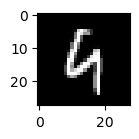

In [10]:
def show_image(img_data: np.ndarray) -> tuple:
    fig, axes = plt.subplots(figsize=(1.60, 1.20))
    axes.imshow(X=img_data, cmap="gray")
    return fig, axes

# print(y_test[5854])
show_image(X_test[4823])
plt.show()

(<Figure size 160x120 with 1 Axes>, <Axes: >)

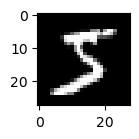

In [11]:
show_image(X_train[0])

### 5.2. Linear and Activation Function:

### 5.3. Loss/Cost Function

### 5.4. Optimizer

In [30]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

Num GPUs Available:  0
